In [1]:
import os
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.stumpf import get_stumpf_log_ratio
from sdb_utils.ml_utils import (
    create_sdb_estimation,
    get_X_y_for_split,
    SplitType,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
puerto_rico_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'puerto_rico_sentinel_merged')
)
load_puerto_rico_eop = LoadTask(puerto_rico_eop_path)

data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_puerto_rico_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task,
)
read_merge_wf = EOWorkflow(nodes)

train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 319, 544, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 319, 544, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 319, 544, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(319, 544, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(319, 544, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(319, 544, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(319, 544, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(319, 544, 1), dtype=int64)
  }
  meta_info={
    test_count: 164983
    test_perc: 0.9507133966439241
    train_count: 8553
    train_perc: 0.04928660335607597
    validation_count: 0
    validation_perc: 0.0
  }
  bbox=BBox(((686070.726989808, 2007089.913413469), (691510.726989808, 2010279.913413469)), crs=CRS('32619'))
  timestamp=[datetime.datetime(2021, 5, 2, 15, 7, 19), datetime.datetime(2021, 5, 2, 15, 7, 4

In [3]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)

_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)

reg = LinearRegression()
reg.fit(X_train, y_train)

score = reg.score(X_train, y_train)
score

0.7121805038497304

In [4]:
ypred = reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, ypred))

1.3331884

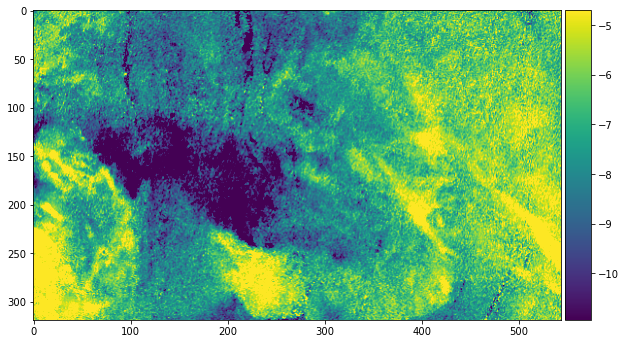

In [5]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

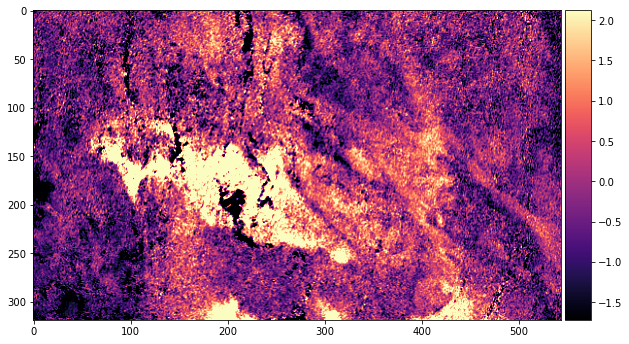

In [6]:
l2a_sdb_errors = l2a_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

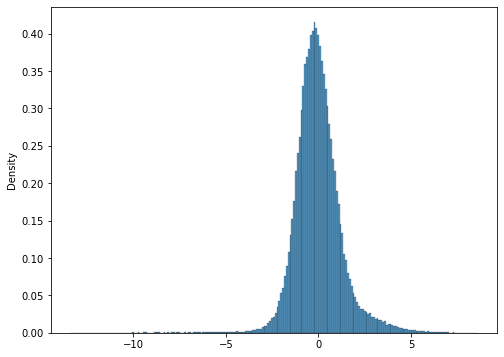

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

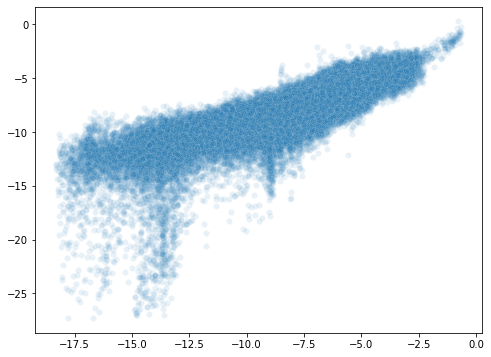

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=l2a_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

In [9]:
np.corrcoef(y_all, l2a_sdb_estimation_values)

array([[1.        , 0.84791851],
       [0.84791851, 1.        ]])

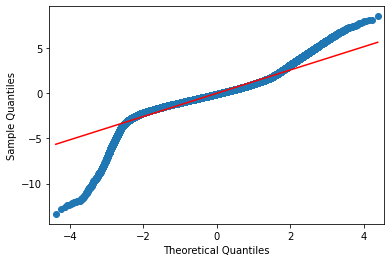

In [10]:
sm.qqplot(l2a_sdb_residuals, line='s')
plt.show()

## Acolite Example

In [11]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)

acolite_product='L2R'
_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), train_mask_single_band)

reg = LinearRegression()
reg.fit(X_train, y_train)

score = reg.score(X_train, y_train)
score

0.6718243727622217

In [12]:
ypred = reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, ypred))

1.4235889

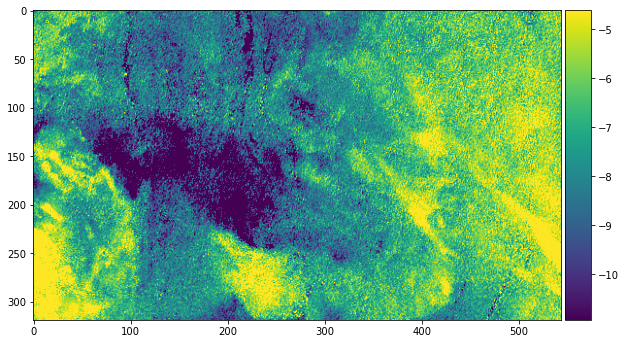

In [13]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), mask_complete_single_band)

acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all)
eolx.visualization.plot_ndarray_band(acolite_sdb_estimation_map, cmap='viridis')
plt.show()

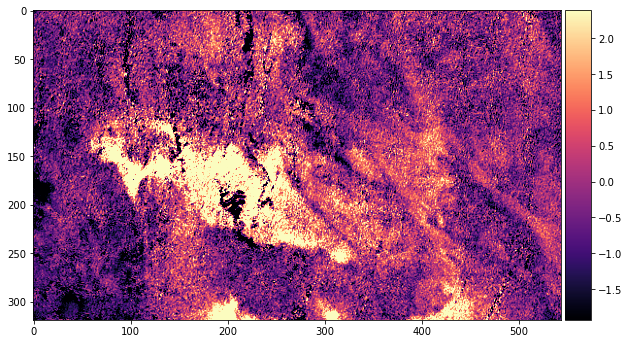

In [14]:
acolite_sdb_errors = acolite_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

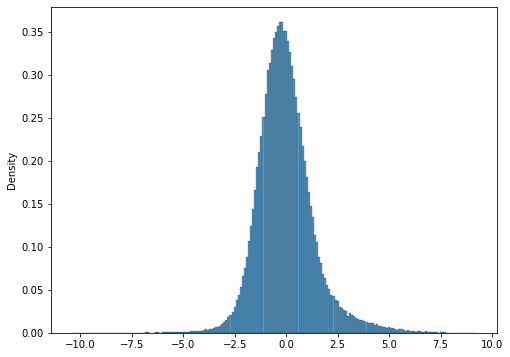

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all
sns.histplot(acolite_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

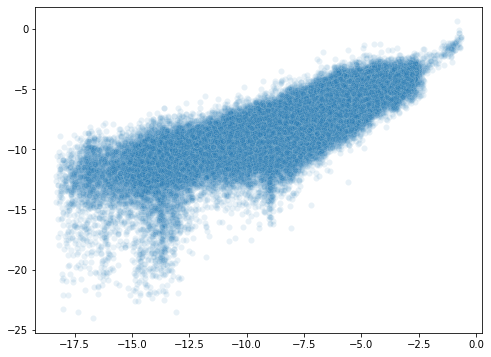

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=acolite_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

In [17]:
np.corrcoef(y_all, acolite_sdb_estimation_values)

array([[1.        , 0.82257842],
       [0.82257842, 1.        ]])

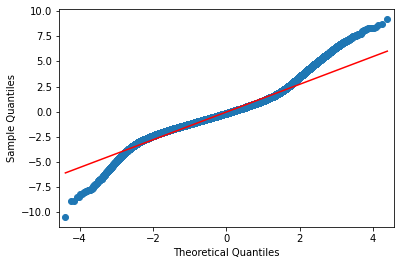

In [18]:
sm.qqplot(acolite_sdb_residuals, line='s')
plt.show()